<a href="https://colab.research.google.com/github/sathwikkes/Yelp-Image-Classification/blob/main/data_wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
# necessary packages/modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import glob 
import os
os.environ['KERAS_BACKEND']='tensorflow' 
import io
import seaborn as sns
from PIL import Image
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
import cv2

## Loading the Data

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
uploaded = files.upload()

Saving photos.json to photos.json


In [4]:
data = pd.read_json(uploaded.get('photos.json'), lines=True)


Resizing all the Images

In [5]:
#-----------------------------------RESIZING images------------------------------------
# you only have to run this cell once
# once resized images cannot revert back to original 
# imagedatagenerator does not work in this situation because we don't have an organized tree
# 128x128 is common practice, on first trial tested 75x75

#dir = "/content/drive/MyDrive/Colab-Notebooks/yelp-image-classification/data/rand_pics"

#for filename in glob.iglob(dir + '/*.jpg'):
#  im = Image.open(filename)
#  imResize = im.resize((128,128), Image.ANTIALIAS)
#  imResize.save(filename, 'JPEG', quality = 90)

### Reading in the Photos

In [6]:
img_dir_train = '/content/drive/MyDrive/Colab-Notebooks/yelp-image-classification/data/rand_pics' 

data_path = os.path.join(img_dir_train,'*g')

files = glob.glob(data_path)

# creaing dictionary with key as photo_id and value as image path
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x 
                     for x in glob.glob(data_path)}


In [7]:
data['path'] = data['photo_id'].map(imageid_path_dict.get)

In [8]:
df = data[data.path.notnull()]

In [9]:
df['class_by_number'] = pd.Categorical(df['label']).codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
classes = ['drink', 'food', 'inside', 'menu', 'outside']
num_classes = len(classes)

In [12]:
df.head()

,photo_id,business_id,caption,label,path,class_by_number,image
636,0bhL0XvLMxn-W-fu2c7pkA,H4E4sZ6PKBef65hU0GKi_g,"Our Kingpin room has 2 lanes, private bar acce...",inside,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,2,"[[[161, 115, 89], [161, 115, 89], [162, 116, 9..."
933,0eFLVEyJhskLZgnbecseKg,PIpCmok4zzozeSI7iT9H9A,,outside,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,4,"[[[136, 154, 200], [135, 153, 199], [132, 153,..."
1044,0FfYeFWmxcJqxwyN5PZPbw,umXvdus9LbC6oxtLdXelFQ,,food,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,1,"[[[81, 40, 36], [103, 65, 62], [130, 97, 92], ..."
1167,0glSs9z_jEE5VYVUwrsFIA,woXlprCuowrLJswWere3TQ,,inside,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,2,"[[[54, 29, 0], [30, 11, 5], [27, 16, 32], [21,..."
1367,0ifISIekaQ9xge4_fXyHwg,2FfZUyA82YhQCjWNiqDCzQ,Inside Lenny's!,inside,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,2,"[[[79, 72, 79], [102, 62, 63], [103, 41, 42], ..."


In [13]:
df['image'].map(lambda x:x.shape).value_counts()

(128, 128, 3)    1000
Name: image, dtype: int64

Create and Compile a Model

1. Build the CNN architecture
    *   N Layer Fully Connected Convolutional Neural Network
2. Run the model
3. Train/Fit the data to the model
4. Evaluate the model on the test set 
5. Error Analysis

## Preprocessing

### Shuffle the data

In [14]:
from sklearn.utils import shuffle
import random
shuffle(df)

,photo_id,business_id,caption,label,path,class_by_number,image
85804,IggyFawmuowdv1r9hsLdWg,2MpSWir6lVaTmJHtLCyP7g,Lots of bagels!,inside,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,2,"[[[148, 131, 121], [149, 132, 122], [148, 134,..."
156832,Te9x0d5VD7hqvXGiMP4FmQ,rqWIntPaV8TpJvgT6H9UNw,,food,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,1,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
31796,9wILSAgtPOgnlEhRv7O6Ow,YB4mu3Q0xGq9uZUV7d11lg,,food,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,1,"[[[36, 22, 19], [37, 23, 20], [37, 24, 18], [3..."
29205,95WQAS-7OQZqwtklMmuPaQ,3ajqOW9A7VhResA08I7RTg,,inside,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,2,"[[[116, 99, 79], [116, 99, 79], [115, 98, 78],..."
191609,YQGg_oHtgLrDTUOLw5sGLQ,MkR70GAWQ2n7el6x5friHQ,,inside,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,2,"[[[173, 155, 131], [159, 139, 114], [136, 115,..."
...,...,...,...,...,...,...,...
16324,55KUcSYFGrk82yvKkz65_g,0EgYXYjt2XJL4hlsKnzrcw,,food,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,1,"[[[95, 94, 102], [117, 116, 124], [104, 104, 1..."
108025,luKEBC8nEOXlTEI5dDGdKQ,o86OGfW63bVqWkIrvxcEQQ,Inside Postinos Scottsdale very mod and love t...,inside,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,2,"[[[88, 56, 31], [91, 59, 34], [90, 56, 29], [8..."
143638,RDiD4-8J5XEoKZK6qIbiQQ,C5KLbK9bxlYo_VE7vZoSHQ,,food,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,1,"[[[16, 16, 4], [24, 20, 9], [65, 52, 44], [41,..."
23918,_7iLZan7BvDWge8VdLB-ig,N6tJKe0h1NJgVm86NDg7ug,Lobster roll,food,/content/drive/MyDrive/Colab-Notebooks/yelp-im...,1,"[[[48, 31, 11], [50, 33, 13], [52, 36, 13], [5..."


### Train, Test, Split the Data

In [15]:
X= np.array(df['image'].values.tolist())
y=np.array(df['class_by_number'].values.tolist())

In [16]:
type(X)

numpy.ndarray

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=43)

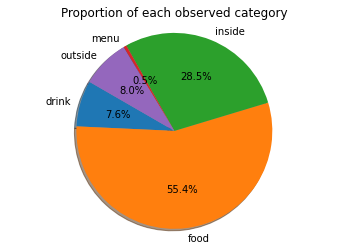

In [18]:
size = np.bincount(y)
explode = (0,0,0,0,0,0)
plt.pie(size,explode=None, labels=classes,autopct = '%1.1f%%', shadow=True, startangle = 150)
plt.axis('equal')
plt.title("Proportion of each observed category")

plt.show()

### Normalizing the data

In [19]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [20]:
X_train /= 255.0
X_test /= 255.0

**Standardization**

In [21]:
#X_train_mean = np.mean(X_train_)
#X_train_std = np.std(X_train_)

#X_test_mean = np.mean(X_test_)
#X_test_std = np.std(X_test_)

#X_train = (X_train_ - X_train_mean)/X_train_std
#X_test = (X_test_ - X_test_mean) / X_test_std

### Reshaping the data

In [22]:
X_train = X_train.reshape(X_train.shape[0], *(128,128,3))
X_test = X_test.reshape(X_test.shape[0], *(128,128,3))

In [23]:
print("Shape of train images is: ", X_train.shape)
print("Shape of test images is: ", X_test.shape)
print("Shape of lables is: ", y_train.shape)
print("Shape of labels is: ", y_test.shape)

Shape of train images is:  (800, 128, 128, 3)
Shape of test images is:  (200, 128, 128, 3)
Shape of lables is:  (800,)
Shape of labels is:  (200,)


In [24]:
def display_image(categories, images, labels, title="Example images from the dataset"):
  """
  branching of the rand_pic function
  displays 25 images with their labels
  """
  fig = plt.figure(figsize=(10,10))
  fig.suptitle(title, fontsize =15)
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # avoid error related to clipping input data
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(categories[labels[i]])
  plt.show()

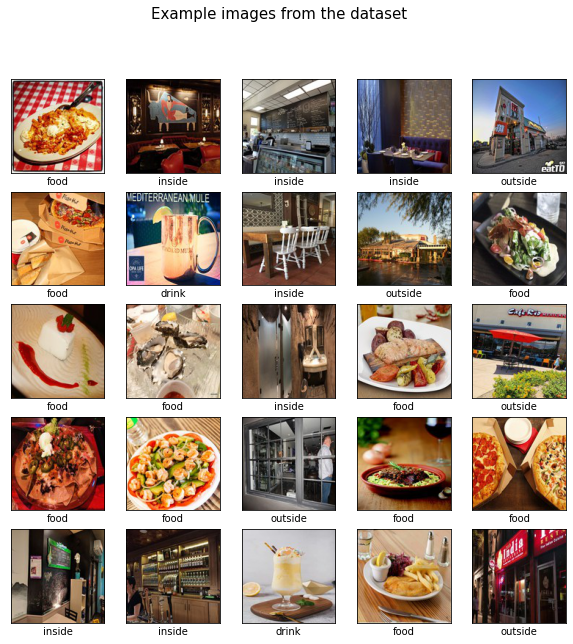

In [25]:
display_image(classes, X_train, y_train)

## Model building

In [26]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Input, Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, MaxPool2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
#from tensorflow.python.keras.preprocessing import image
#from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.python import keras 

### Building CNN

In [27]:
# Initializing a Sequential model
model = Sequential()

#Input Layer  
model.add(Conv2D(32,kernel_size= (3,3),padding="same", activation = 'relu', input_shape = (128,128,3)))

#Convolutional Layers - blocks 
model.add(Conv2D(32,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Dropout(0.20)) 

model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
model.add(Conv2D(64,(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(128, (3,3), padding="same", activation='relu'))
model.add(Conv2D(128,(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.20))


model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#Fully Connected Layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(5, activation = 'softmax'))

In [28]:
#summary of the model
#inspecting the number of layers, parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [29]:
#compile the model 
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.00001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
#fitting the model 
history = model.fit(X_train, y_train, validation_split=0.20, epochs = 40)

Epoch 1/40
20/20 [==============================] - 29s 73ms/step - loss: 1.5651 - accuracy: 0.3401 - val_loss: 1.4978 - val_accuracy: 0.5813
Epoch 2/40
20/20 [==============================] - 1s 39ms/step - loss: 1.3154 - accuracy: 0.5674 - val_loss: 1.2429 - val_accuracy: 0.5813
Epoch 3/40
20/20 [==============================] - 1s 39ms/step - loss: 1.1018 - accuracy: 0.5853 - val_loss: 1.2010 - val_accuracy: 0.5813
Epoch 4/40
20/20 [==============================] - 1s 39ms/step - loss: 1.1670 - accuracy: 0.5486 - val_loss: 1.1993 - val_accuracy: 0.5813
Epoch 5/40
20/20 [==============================] - 1s 39ms/step - loss: 1.1597 - accuracy: 0.5503 - val_loss: 1.1778 - val_accuracy: 0.5813
Epoch 6/40
20/20 [==============================] - 1s 39ms/step - loss: 1.1234 - accuracy: 0.5769 - val_loss: 1.1764 - val_accuracy: 0.5813
Epoch 7/40
20/20 [==============================] - 1s 39ms/step - loss: 1.0897 - accuracy: 0.5768 - val_loss: 1.1728 - val_accuracy: 0.5813
Epoch 8/40
2

### Visualizing Network Architecture

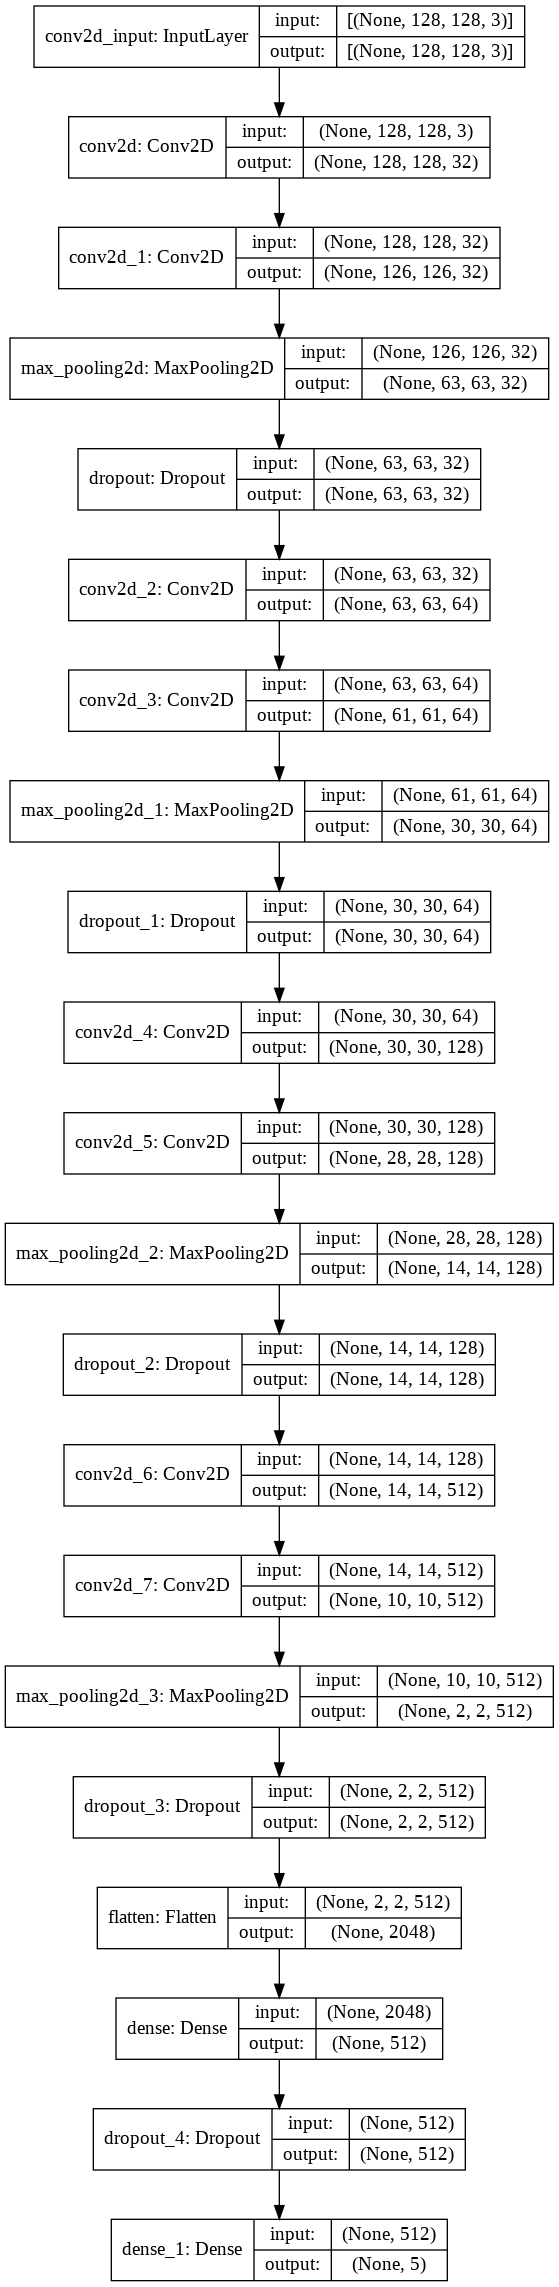

In [31]:
# outputting the plot for the CNN
#SVG(model_to_dot(model, show_shapes=True).create(prog="dot", format="svg"))
plot_model(model, show_shapes=True, to_file='model.png')

### Evaluation

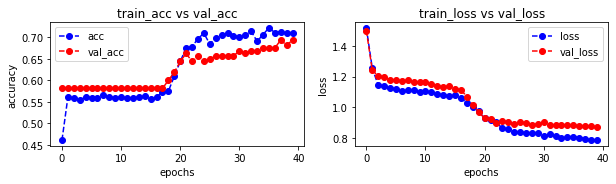

In [32]:
fig = plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo--', label='acc')
plt.plot(history.history['val_accuracy'], 'ro--',label='val_acc')
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()


plt.subplot(222)
plt.plot(history.history['loss'], 'bo--', label="loss")
plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
plt.title('train_loss vs val_loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.show()

In [33]:
loss_test =model.evaluate(X_test,y_test)

7/7 [==============================] - 1s 36ms/step - loss: 0.8894 - accuracy: 0.6950


In [34]:
preds= model.predict(X_test)
pred_labels = np.argmax(preds, axis=1)

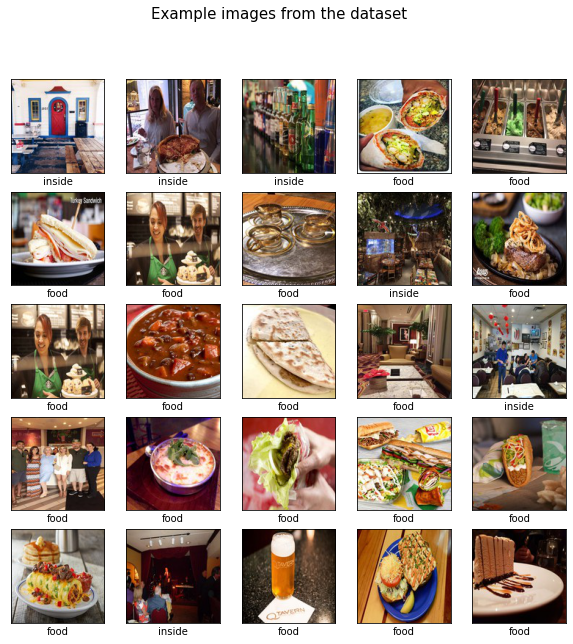

In [35]:
display_image(classes, X_test, pred_labels)

In [36]:
def output_mistakened_images(categories, test_pics,test_labels,pred_labels):
  """
  
  prints mislabeled images by classifier when test_labels != pred_labels
  
  """

  incorrect = (test_labels == pred_labels)
  mislabeled_indices = np.where(incorrect==0)
  mislabeled_images = test_pics[mislabeled_indices]
  mislabeled_labels = pred_labels[mislabeled_indices]

  title = "examples of misclassified images"
  display_image(categories, mislabeled_images, mislabeled_labels, title)

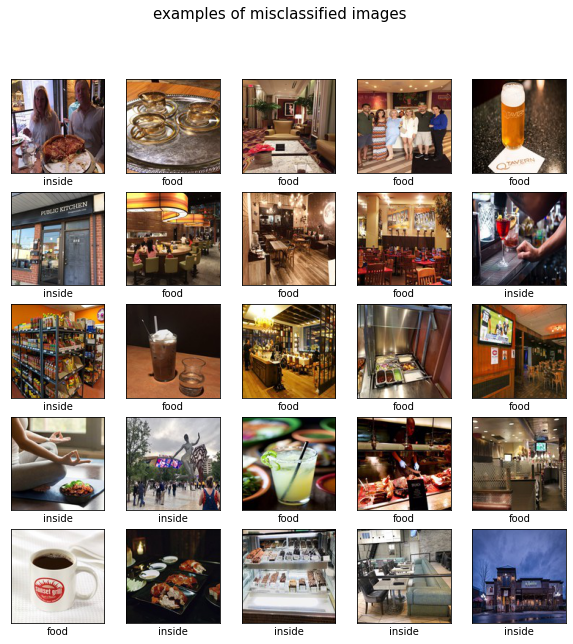

In [37]:
output_mistakened_images(classes,X_test, y_test, pred_labels)

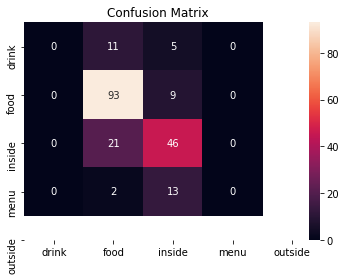

In [38]:
ConfM = confusion_matrix(y_test, pred_labels)
ax = plt.axes()
sns.heatmap(ConfM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=classes, 
           yticklabels=classes, ax = ax)
ax.set_title('Confusion Matrix')
plt.show()

In [39]:
#print("Evaluate on test data")
#y_pred_keras = model.predict(X_test)
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

## Hyperparameter Tuning

In [40]:
def run_model(optimizer='adam'):
  
  # initializing a sequential model
  model = Sequential()
  
  # convolution blocks 
  model.add(Conv2D(32,(3,3),activation = 'relu', padding="same", input_shape = (128,128,3)))
  model.add(Conv2D(32, (3,3), activation='relu')) 
  model.add(MaxPooling2D(2,2)) #pooling
  model.add(Dropout(0.25)) #dropout

  model.add(Conv2D(64, (3,3), activation="relu", padding="same"))
  model.add(Conv2D(64,(3,3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation = 'softmax'))
  model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.00001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return model 

In [41]:
keras_model = KerasClassifier(build_fn= run_model, verbose=0)

### GridSearchCV

In [42]:
batch_size = [20,50,100]
epochs = [10, 15, 20,25]
optimizer = ['adam', 'SGD', 'RMSprop']
learn_rate = [0.0001, 0.001, 0.01]
param_grid = dict(batch_size = batch_size, epochs = epochs, optimizer = optimizer)
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, n_jobs = 1, cv=3)

In [43]:
gcv_result = grid.fit(X, y)

In [44]:
print("Best accuracy: {}\nBest Combination: {}".format(gcv_result.best_score_, gcv_result.best_params_))

Best accuracy: 0.623977263768514
Best Combination: {'batch_size': 20, 'epochs': 25, 'optimizer': 'SGD'}


In [45]:
means = gcv_result.cv_results_['mean_test_score']
stds = gcv_result.cv_results_['std_test_score']
params = gcv_result.cv_results_['params']

#for mean, stdev, param in zip(means, stds, params):
#  print("%f (%f) with: %r" % (mean,stdev, param))

In [46]:
results_df = pd.DataFrame(params)
results_df["mean"] = means
results_df['std'] = stds

In [47]:
results_df.head()

,batch_size,epochs,optimizer,mean,std
0,20,10,adam,0.598029,0.025334
1,20,10,SGD,0.598008,0.008432
2,20,10,RMSprop,0.565997,0.010015
3,20,15,adam,0.594999,0.004937
4,20,15,SGD,0.597031,0.026495


In [48]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
results = cross_val_score(keras_model, X, y, cv=kfold)
print(results.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


0.5739999949932099


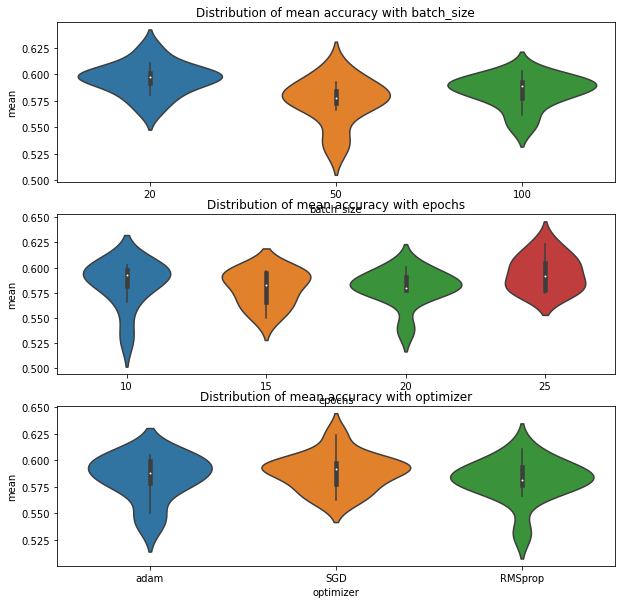

In [49]:
param_ = ['batch_size', "epochs","optimizer"]
fig, ax = plt.subplots(3,1,figsize=(10,10), squeeze=False)
ax = ax.ravel()
for i in range(3):
  ax[i].set_title("Distribution of mean accuracy with {}".format(param_[i]))
  sns.violinplot(x=param_[i], y = 'mean', data = results_df, ax=ax[i])
#fig.tight_layout(pad=0)

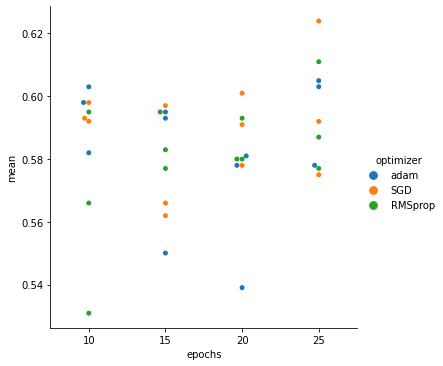

In [50]:
sns.catplot(x='epochs', y='mean', hue='optimizer', kind='swarm', data=results_df)

### Saving Model

In [51]:
#MODEL_FILE = "/content/drive/MyDrive/Colab-Notebooks/yelp-image-classification/models/CNN_ADAM3-Improved.model"

In [52]:
#model.save(MODEL_FILE)